# Data ingestion and data processing pipelines

In [1]:
import cv2
import numpy as np
import bm3d
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
import matplotlib.pyplot as plt
import os
import glob
import shutil

In [2]:
def process_and_segment_image(image_path, save_dir="output"):
    """
    Processes and segments a melanoma image, isolates the masked area, its inverse, 
    applies Canny edge detection, and saves each stage.
    
    Parameters:
        image_path (str): Path to the input image.
        save_dir (str): Directory to save the output images.
    
    Returns:
        dict: Dictionary containing intermediate and final results:
              - grayscale: Grayscale version of the image.
              - denoised: Noise-reduced image using BM3D.
              - binary_mass: Binary mass lesion image.
              - binary_mask: Binary lesion mask formed by thresholding.
              - morphed: Image after morphological operations.
              - segmented: Final segmented image.
              - masked_area: ROI showing only the masked area of the image.
              - inverse_masked_area: Image showing everything except the masked area.
              - edges: Canny edge-detected image.
    """
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    # Resize to 256x256
    resized_image = cv2.resize(image, (256, 256))
    
    # Convert to grayscale
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(save_dir, "grayscale.png"), grayscale_image)
    
    # Apply BM3D for noise reduction
    denoised_image = bm3d.bm3d(grayscale_image, sigma_psd=15, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    cv2.imwrite(os.path.join(save_dir, "denoised.png"), (denoised_image * 255).astype(np.uint8))
    
    # Binary lesion mass using thresholding
    binary_mass = (denoised_image > threshold_otsu(denoised_image)).astype(np.uint8) * 255
    cv2.imwrite(os.path.join(save_dir, "binary_mass.png"), binary_mass)
    
    # Create binary lesion mask using maximum entropy thresholding
    max_entropy_threshold = threshold_otsu(grayscale_image)
    binary_mask = (grayscale_image > max_entropy_threshold).astype(np.uint8) * 255
    cv2.imwrite(os.path.join(save_dir, "binary_mask.png"), binary_mask)
    
    # Apply morphological operations
    morphed_image = closing(binary_mask, square(3))
    cv2.imwrite(os.path.join(save_dir, "morphed.png"), morphed_image)
    
    # Create the segmented image
    segmented_image = cv2.bitwise_and(grayscale_image, grayscale_image, mask=morphed_image)
    cv2.imwrite(os.path.join(save_dir, "segmented.png"), segmented_image)
    
    # Extract only the masked area
    masked_area = cv2.bitwise_and(resized_image, resized_image, mask=morphed_image)
    cv2.imwrite(os.path.join(save_dir, "masked_area.png"), masked_area)
    
    # Extract the inverse of the masked area
    inverse_mask = cv2.bitwise_not(morphed_image)  # Invert the mask
    inverse_masked_area = cv2.bitwise_and(resized_image, resized_image, mask=inverse_mask)
    cv2.imwrite(os.path.join(save_dir, "inverse_masked_area.png"), inverse_masked_area)
    
    # Apply Canny edge detection
    edges = cv2.Canny(inverse_masked_area, threshold1=50, threshold2=150)
    cv2.imwrite(os.path.join(save_dir, "edges.png"), edges)
    
    # Plot and save all stages
    stages = {
        "Grayscale": grayscale_image,
        "Denoised": (denoised_image * 255).astype(np.uint8),
        "Binary Mass": binary_mass,
        "Binary Mask": binary_mask,
        "Morphed": morphed_image,
        "Segmented": segmented_image,
        "Masked Area": cv2.cvtColor(masked_area, cv2.COLOR_BGR2RGB),  # Convert BGR to RGB
        "Inverse Masked Area": cv2.cvtColor(inverse_masked_area, cv2.COLOR_BGR2RGB),
        "Edges": edges
    }
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for ax, (title, img) in zip(axes.flatten(), stages.items()):
        ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "processing_stages.png"))
    plt.show()
    
    return stages

In [3]:
# # Example usage
# image_path = os.path.join('..', 'artifacts', 'dataset', 'raw', 'train', 'malignant', 'melanoma_5011.jpg')
# process_and_segment_image(image_path, save_dir="output_images")

In [4]:
def copy_file(source_path, destination_path):
    """
    Copies a file from source_path to destination_path.
    If the source directory does not exist, creates the necessary directories.

    Parameters:
        source_path (str): The path of the file to be copied.
        destination_path (str): The destination path where the file should be copied.
    
    Returns:
        str: A success message if the file is copied successfully or the source file is created.
    """
    try:
        # Ensure the source file's directory exists
        source_dir = os.path.dirname(source_path)
        if not os.path.exists(source_dir):
            os.makedirs(source_dir)
            # Create an empty source file as it does not exist
            open(source_path, 'w').close()  # Create an empty file

        # Ensure the destination directory exists
        destination_dir = os.path.dirname(destination_path)
        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)

        # Copy the file
        shutil.copy(source_path, destination_path)

        return f"File '{source_path}' has been successfully copied to '{destination_path}'."

    except Exception as e:
        raise Exception(f"An error occurred: {e}")

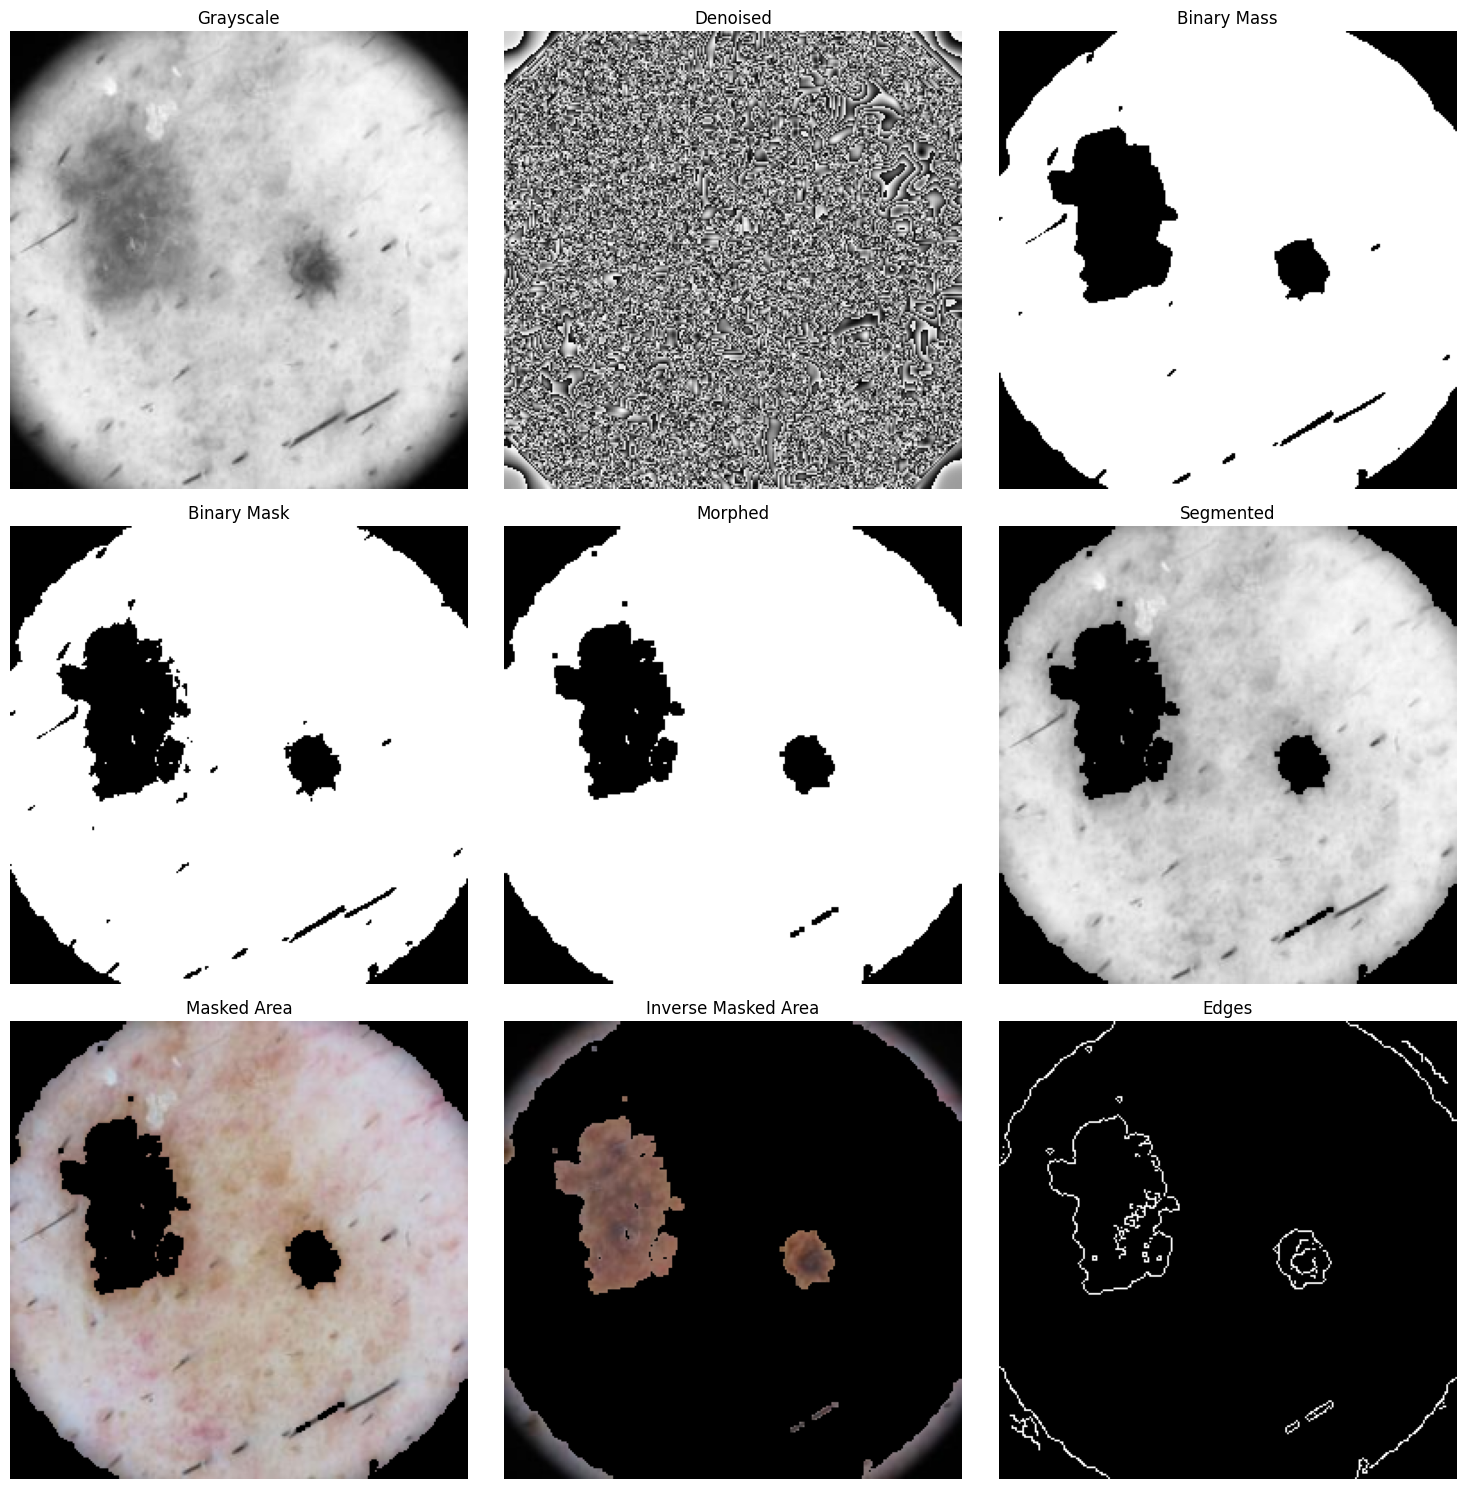

..\artifacts\dataset\raw\train\malignant\melanoma_5000.jpg, ..\artifacts\dataset\processed\train\malignant\melanoma_5000.jpg


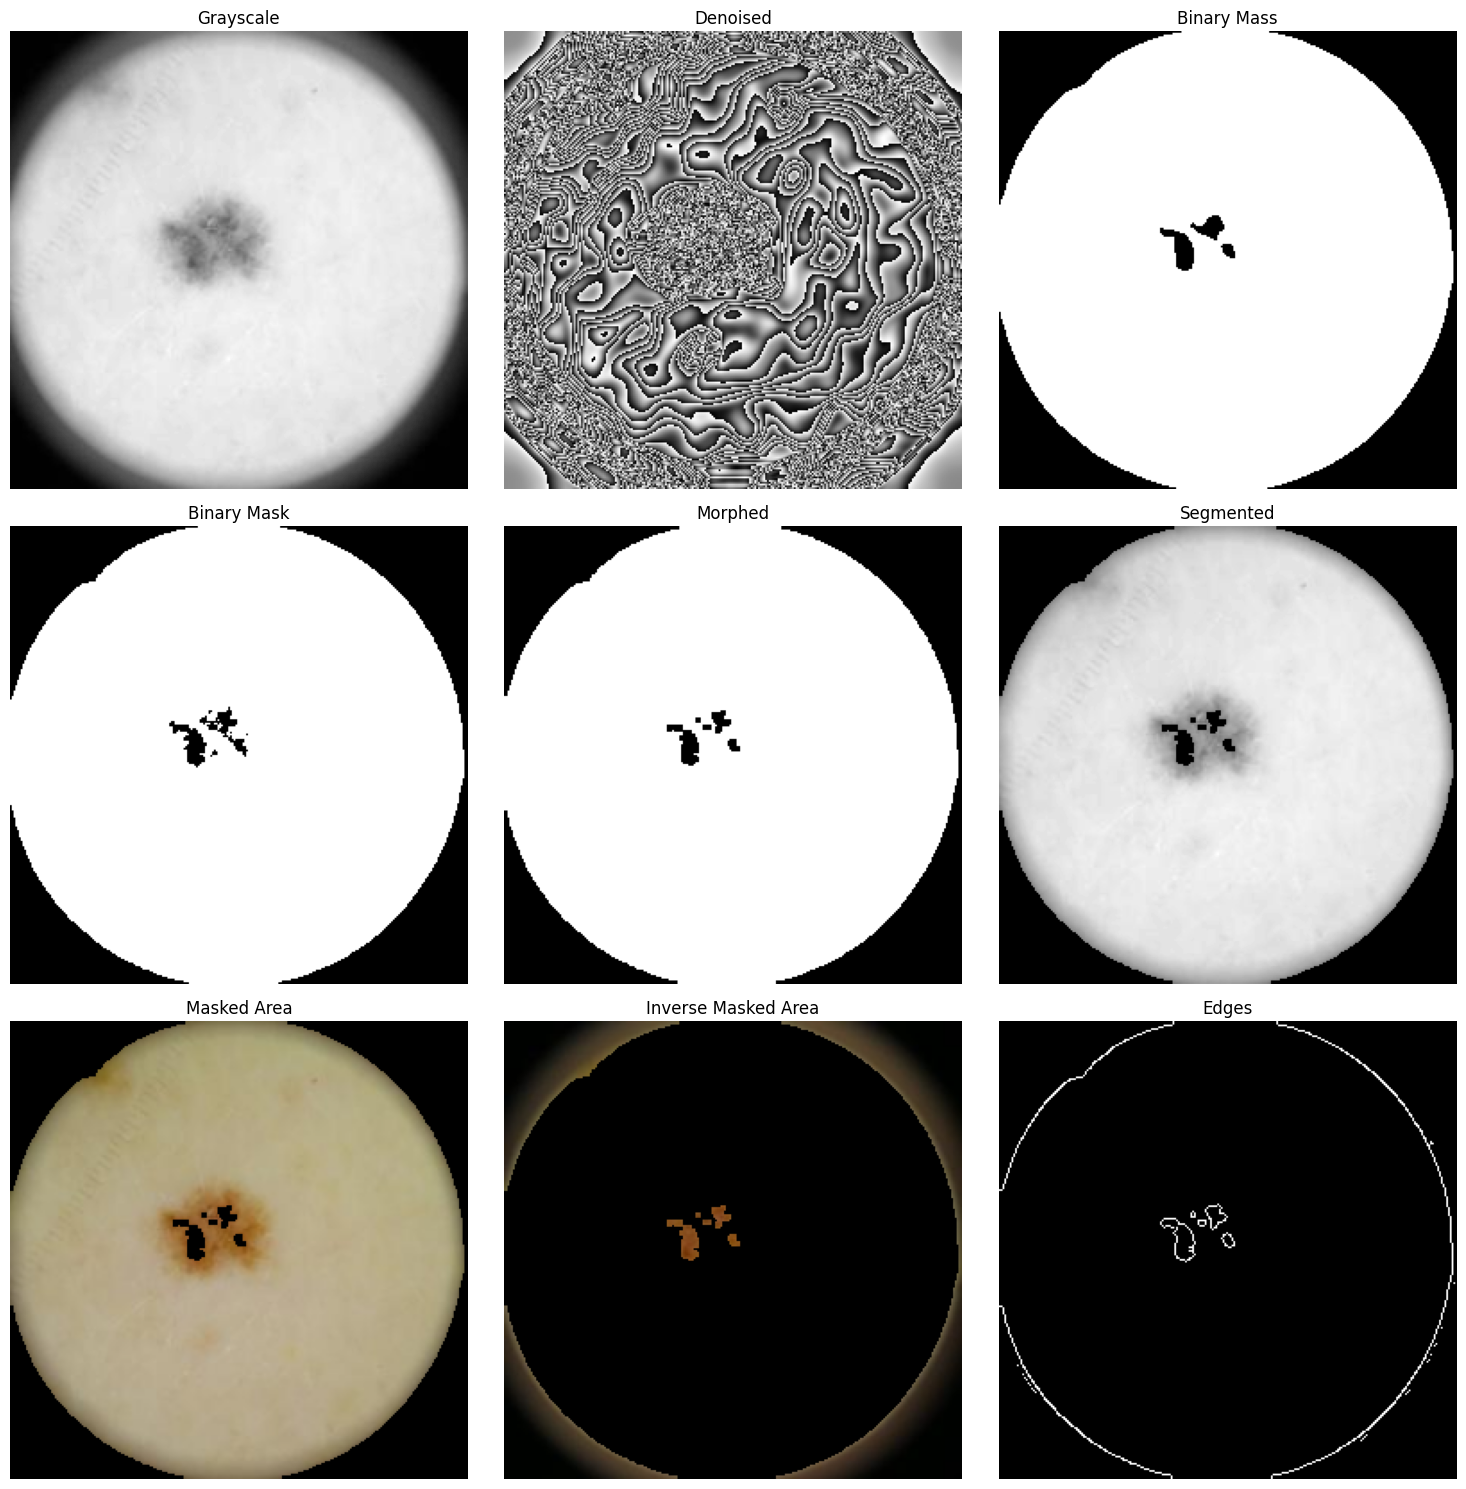

..\artifacts\dataset\raw\train\malignant\melanoma_5001.jpg, ..\artifacts\dataset\processed\train\malignant\melanoma_5001.jpg


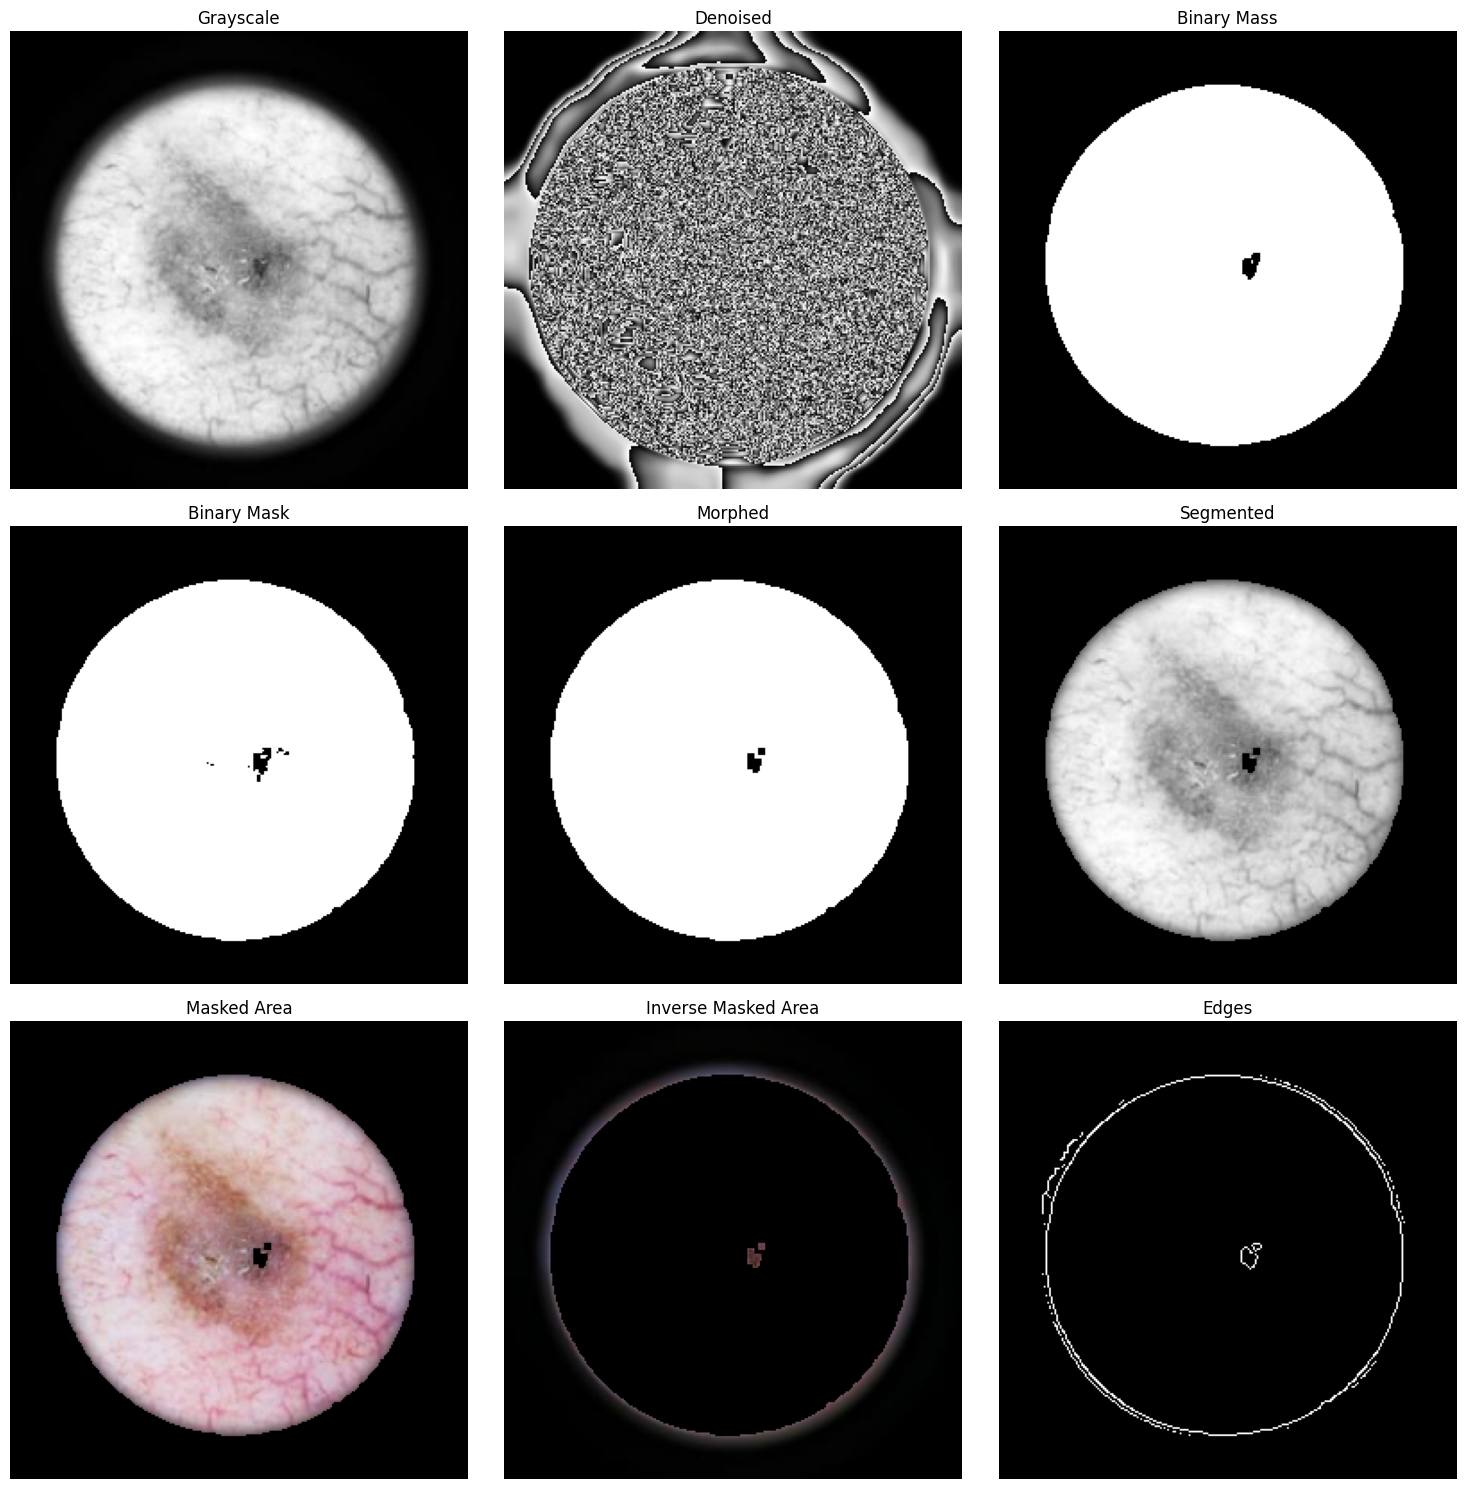

..\artifacts\dataset\raw\train\malignant\melanoma_5002.jpg, ..\artifacts\dataset\processed\train\malignant\melanoma_5002.jpg


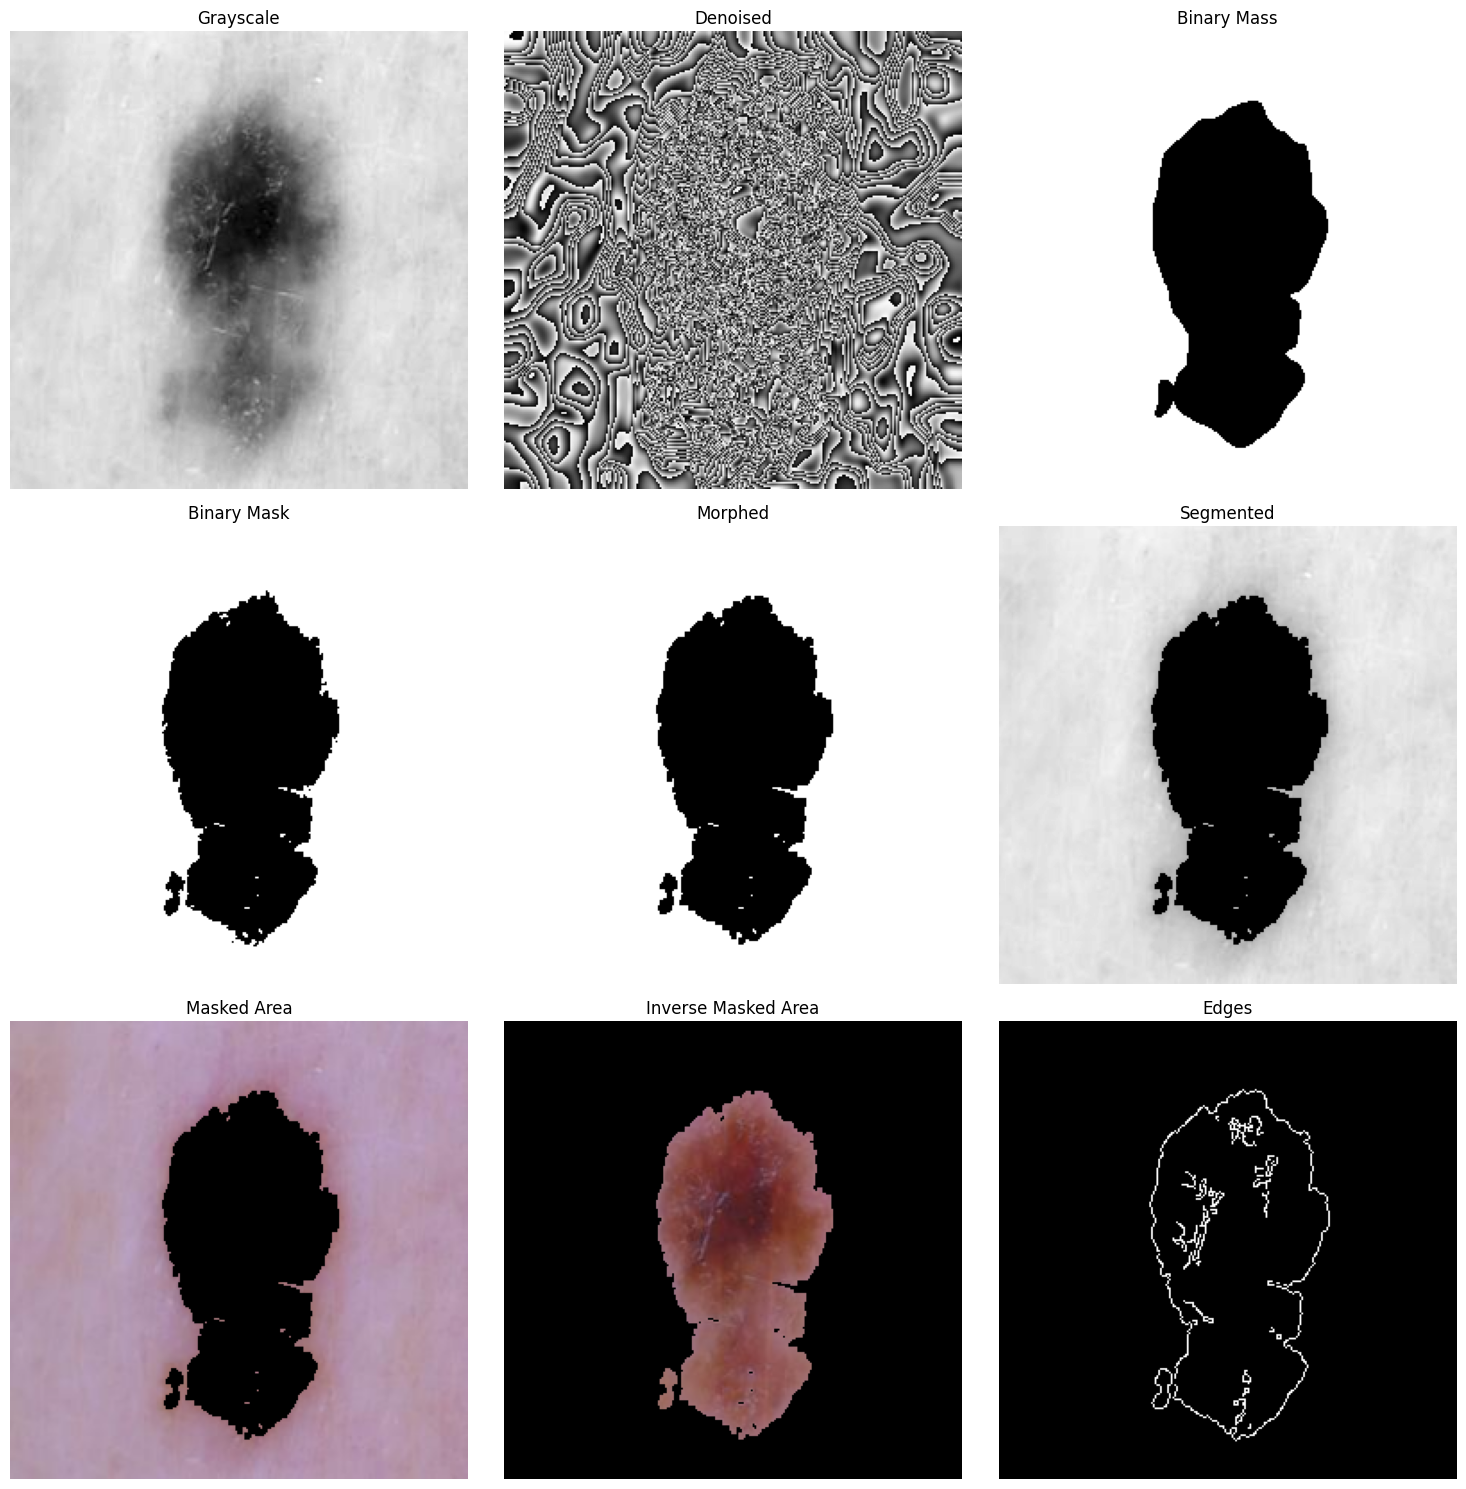

..\artifacts\dataset\raw\train\malignant\melanoma_5003.jpg, ..\artifacts\dataset\processed\train\malignant\melanoma_5003.jpg
CPU times: total: 38.3 s
Wall time: 19.3 s


In [7]:
%%time
RAW_PATH = os.path.join('..', 'artifacts', 'dataset', 'raw')
PROCESSED_PATH = os.path.join('..', 'artifacts', 'dataset', 'processed')
RAW_IMAGE_PATH = os.path.join(RAW_PATH, 'train', 'malignant', '*')

co = 0

for image_path in glob.glob(RAW_IMAGE_PATH):
    
    save_dir="output_images"
    processed_images_stages = process_and_segment_image(image_path, save_dir=save_dir)
    processed_image = os.path.join(save_dir, 'inverse_masked_area.png')
    image_path_dir_list = image_path.split('\\')
    saved_to_image = os.path.join(PROCESSED_PATH, image_path_dir_list[-3], image_path_dir_list[-2], image_path_dir_list[-1])  
    copy_file(processed_image, saved_to_image)
    print(f"{image_path}, {saved_to_image}")
    
    co += 1
    if co == 4:
        break
